In [2]:
# Import libraries
from __future__ import print_function


import numpy as np
import pandas as pd
import psycopg2
import socket
import sys
import os
import getpass

from collections import OrderedDict

from sepsis_utils import sepsis_utils as su
from sepsis_utils import roc_utils as ru

# path to output data files to - can be relative to the current folder
data_path = 'data'

In [1]:
import datetime

In [3]:
# colours for prettier plots
import matplotlib
import matplotlib.pyplot as plt
import colorsys
def gg_color_hue(n):
    hues = np.linspace(15, 375, n)
    hsv_tuples = [(x*1.0/360.0, 0.5, 0.8) for x in hues]
    rgb_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples)
    return rgb_tuples

marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']

# plot settings
%matplotlib inline
plt.style.use('ggplot')
font = {'size'   : 20}
matplotlib.rc('font', **font)

In [4]:
# helper function for generating tables
# this rolls back the cursor if it fails
def execute_query_safely(sql, con):
    cur = con.cursor()
    
    # try to execute the query
    try:
        cur.execute(sql)
    except:
        # if an exception, rollback, rethrow the exception - finally closes the connection
        cur.execute('rollback;')
        raise
    finally:
        cur.close()
    
    return

In [5]:
sqluser = getpass.getuser()
print('Using username {}'.format(sqluser))

dbname = 'mimic'
schema_name = 'mimiciii'
query_schema = 'SET search_path to public,' + schema_name + ';'

Using username work


In [6]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user='postgres', password="19910422")

print('Connected to postgres {}.{}.{}!'.format(int(con.server_version/10000),
                                              (con.server_version - int(con.server_version/10000)*10000)/100,
                                              (con.server_version - int(con.server_version/100)*100)))

Connected to postgres 15.0.02.2!


In [8]:
# check if the sepsis3_cohort table exists ... if not we must generate it
query = """
SELECT EXISTS(SELECT 1 FROM information_schema.tables 
              WHERE table_catalog = '{}'
              AND table_schema in ('public','{}')
              AND table_name = 'sepsis3');
""".format(dbname, schema_name)
tbl_exists = pd.read_sql_query(query, con)
tbl_exists = tbl_exists.loc[0,'exists']
if tbl_exists:
    print('Found the `sepsis3` table. Skipping generation of data in SQL.')
else:
    print('Running SQL code to generate tables. This may take some time.')
    
#     # read through the "make-tables.sql" file in the sql subfolder
#     query_path = 'query'
    
#     with open(os.path.join(query_path, 'make-tables.sql'), 'r') as fp:
#         for line in fp.readlines():
#             if len(line)<2:
#                 print(line,end='')
#                 continue
            
#             if line[0:2] != '\i':
#                 print(line,end='')
#                 continue
                
#             # lines which begin with '\i' call SQL files that generate tables
#             query_file = os.path.join(query_path, line[3:].replace('\n',''))
#             print('Running {} ...'.format(query_file), end=' ')
#             with open(query_file, 'r') as fp_query:
#                 query = ''.join(fp_query.readlines())
#             execute_query_safely(query_schema + query, con)
#             print('done.')

Found the `sepsis3` table. Skipping generation of data in SQL.


/Users/work/anaconda/envs/project/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [12]:
 # read through the "make-tables.sql" file in the sql subfolder
query_path = 'query'
    
with open(os.path.join(query_path, 'make-tables.sql'), 'r') as fp:
    for line in fp.readlines():
        if len(line)<2:
            print(line,end='')
            continue
            
        if line[0:2] != '\i':
            print(line,end='')
            continue
                
        # lines which begin with '\i' call SQL files that generate tables
        query_file = os.path.join(query_path, line[3:].replace('\n',''))
        print('Running {} ...'.format(query_file), end=' ')
        with open(query_file, 'r') as fp_query:
            query = ''.join(fp_query.readlines())
        execute_query_safely(query_schema + query, con)+
        print('done.')

-- As the script is generating many tables, it may take some time.

-- We assume the database and the search path are set correctly.
-- You can set the search path as follows:
-- SET SEARCH_PATH TO public,mimiciii;
-- This will create tables on public and read tables from mimiciii

BEGIN;
-- ----------------------------- --
-- ---------- STAGE 1 ---------- --
-- ----------------------------- --

-- \i tbls/abx-poe-list.sql
-- \i tbls/abx-micro-prescription.sql
-- \i tbls/suspicion-of-infection.sql

-- -- blood cultures around ICU admission
-- \i tbls/blood-culture-icu-admit.sql

-- -- generate cohort
-- -- \i tbls/cohort.sql

-- -- generate sepsis definitions
-- \i ../mimic-code/concepts/sepsis/angus.sql
-- \i ../mimic-code/concepts/sepsis/martin.sql
-- \i ../mimic-code/concepts/sepsis/explicit.sql


-- -- Generate the views which the severity scores are based on (at time of infection)
-- \i tbls/urine-output-infect-time.sql
-- \i tbls/vitals-infect-time.sql
-- \i tbls/gcs-infect-time.

In [7]:
# exclusion criteria:
#   - less than 16 years old
#   - never have any chartevents data (i.e. likely administrative error)
#   - not cardiac surgery
#   - suspected of infection
#   - first ICU stay
#   - not a CareVue patient (i.e. admitted 2008-2012)
# these exclusion criteria are created in the sepsis3_cohort table
query = query_schema + "select * from sepsis3_cohort"
co = pd.read_sql_query(query,con)

/Users/work/anaconda/envs/project/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [8]:
co

,hadm_id,icustay_id,intime,outtime,age,gender,ethnicity,first_service,dbsource,suspected_of_infection_poe,...,positiveculture_poe,antibiotic_time_poe,exclusion_secondarystay,exclusion_nonadult,exclusion_csurg,exclusion_carevue,exclusion_early_suspicion,exclusion_late_suspicion,exclusion_bad_data,excluded
0,152234,200001,2181-11-25 19:06:12,2181-11-28 20:59:25,61.0499,F,ASIAN - ASIAN INDIAN,MED,metavision,1,...,0.0,2181-11-18,1,0,0,0,1,0,0,1
1,163557,200003,2199-08-02 19:50:04,2199-08-08 17:09:18,48.2940,M,WHITE,SURG,carevue,1,...,1.0,2199-08-02,0,0,0,1,0,0,0,1
2,189514,200006,2159-09-03 11:28:14,2159-09-04 19:08:10,54.0710,M,OTHER,MED,carevue,0,...,NaN,NaT,1,0,0,1,0,0,0,1
3,129310,200007,2109-02-17 10:03:37,2109-02-18 17:03:12,43.3439,M,WHITE,CMED,carevue,0,...,NaN,NaT,0,0,0,1,0,0,0,1
4,129607,200009,2189-11-30 10:34:32,2189-12-02 14:17:37,47.5548,F,WHITE,CSURG,carevue,1,...,NaN,2189-11-30,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,169431,299993,2149-11-13 21:01:05,2149-11-16 16:57:30,26.2264,M,WHITE,SURG,carevue,0,...,NaN,NaT,0,0,0,1,0,0,0,1
61528,177406,299994,2114-12-09 11:56:00,2114-12-15 20:29:14,74.2165,F,WHITE,MED,carevue,1,...,0.0,2114-12-13,1,0,0,1,0,1,0,1
61529,134959,299995,2116-03-04 17:44:39,2116-03-06 18:03:55,23.3763,M,WHITE,NMED,carevue,1,...,0.0,2116-03-04,0,0,0,1,0,0,0,1
61530,158288,299998,2181-07-05 18:47:40,2181-07-07 17:24:38,86.9560,M,WHITE,GU,metavision,1,...,0.0,2181-07-05,0,0,0,0,0,0,0,0


# Exclusions - applied independently

In [17]:
# print out the exclusions
print('Cohort - initial size: {} ICU stays'.format(co.shape[0]))
idxRem = np.zeros(co.shape[0])
for c in co.columns:
    if c.startswith('exclusion_'):
        print('  {:5g} ({:2.2f}%) - {}'.format(np.sum(co[c]),np.mean(co[c])*100.0, c))
        idxRem[co[c].values==1] = 1
        
print('Final cohort size: {} ICU stays ({:2.2f}%).'.format(co.shape[0] - np.sum(idxRem), (1-np.mean(idxRem))*100.0))

Cohort - initial size: 61532 ICU stays
  15056 (24.47%) - exclusion_secondarystay
   8109 (13.18%) - exclusion_nonadult
   7343 (11.93%) - exclusion_csurg
  37912 (61.61%) - exclusion_carevue
   9550 (15.52%) - exclusion_early_suspicion
   2808 (4.56%) - exclusion_late_suspicion
    491 (0.80%) - exclusion_bad_data
Final cohort size: 11325.0 ICU stays (18.41%).


In [18]:
co

,hadm_id,icustay_id,intime,outtime,age,gender,ethnicity,first_service,dbsource,suspected_of_infection_poe,...,positiveculture_poe,antibiotic_time_poe,exclusion_secondarystay,exclusion_nonadult,exclusion_csurg,exclusion_carevue,exclusion_early_suspicion,exclusion_late_suspicion,exclusion_bad_data,excluded
0,152234,200001,2181-11-25 19:06:12,2181-11-28 20:59:25,61.0499,F,ASIAN - ASIAN INDIAN,MED,metavision,1,...,0.0,2181-11-18,1,0,0,0,1,0,0,1
1,163557,200003,2199-08-02 19:50:04,2199-08-08 17:09:18,48.2940,M,WHITE,SURG,carevue,1,...,1.0,2199-08-02,0,0,0,1,0,0,0,1
2,189514,200006,2159-09-03 11:28:14,2159-09-04 19:08:10,54.0710,M,OTHER,MED,carevue,0,...,NaN,NaT,1,0,0,1,0,0,0,1
3,129310,200007,2109-02-17 10:03:37,2109-02-18 17:03:12,43.3439,M,WHITE,CMED,carevue,0,...,NaN,NaT,0,0,0,1,0,0,0,1
4,129607,200009,2189-11-30 10:34:32,2189-12-02 14:17:37,47.5548,F,WHITE,CSURG,carevue,1,...,NaN,2189-11-30,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,169431,299993,2149-11-13 21:01:05,2149-11-16 16:57:30,26.2264,M,WHITE,SURG,carevue,0,...,NaN,NaT,0,0,0,1,0,0,0,1
61528,177406,299994,2114-12-09 11:56:00,2114-12-15 20:29:14,74.2165,F,WHITE,MED,carevue,1,...,0.0,2114-12-13,1,0,0,1,0,1,0,1
61529,134959,299995,2116-03-04 17:44:39,2116-03-06 18:03:55,23.3763,M,WHITE,NMED,carevue,1,...,0.0,2116-03-04,0,0,0,1,0,0,0,1
61530,158288,299998,2181-07-05 18:47:40,2181-07-07 17:24:38,86.9560,M,WHITE,GU,metavision,1,...,0.0,2181-07-05,0,0,0,0,0,0,0,0


# Exclusions - applied sequentially

In [19]:
# print out the exclusions *SEQUENTIALLY* - i.e. if already excluded, don't re-print
print('Cohort - initial size: {} ICU stays'.format(co.shape[0]))

COL_REM = ['exclusion_nonadult', 'exclusion_secondarystay',
           'exclusion_csurg','exclusion_carevue',
           'exclusion_early_suspicion', 'exclusion_late_suspicion', 'exclusion_bad_data']

idxRem = np.zeros(co.shape[0])
for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/co.shape[0], c))
    idxRem[co[c].values==1] = 1
        
print('Final non-suspected cohort size: {:g} ICU stays ({:2.2f}%).'.format(co.shape[0] - np.sum(idxRem), (1-np.mean(idxRem))*100.0))

print()
# define idxRem to exclude non-metavision admissions initially
print('=============================')
print('====== METAVISION ONLY ======')
print(' Patients admitted 2008-2012 ')
print('=============================')
print()

idxRem = co['dbsource']!='metavision'
N = np.sum(~idxRem)
N_IGNORE = np.sum(idxRem)

# print out the exclusions *SEQUENTIALLY* - i.e. if already excluded, don't re-print
print('Cohort - initial size: {} ICU stays'.format(N))

for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/N, c))
    idxRem[co[c].values==1] = True
        
print('Final non-suspected cohort size: {}/{} ICU stays ({:2.2f}%).'.format(
        np.sum(~idxRem), N, np.sum(~idxRem)*100.0/N))
print('')

print('Of these patients...')
c='suspected_of_infection_poe'
N_REM = np.sum( (~idxRem) & (co[c].values==1) )
print('  {:5g} ({:2.2f}%) - {}'.format(N_REM, N_REM*100.0/ np.sum(~idxRem), c))

Cohort - initial size: 61532 ICU stays
   8109 (13.18%) - exclusion_nonadult
  14826 (24.09%) - exclusion_secondarystay
   5905 (9.60%) - exclusion_csurg
  18909 (30.73%) - exclusion_carevue
   1719 (2.79%) - exclusion_early_suspicion
    721 (1.17%) - exclusion_late_suspicion
     18 (0.03%) - exclusion_bad_data
Final non-suspected cohort size: 11325 ICU stays (18.41%).

====== METAVISION ONLY ======
 Patients admitted 2008-2012 

Cohort - initial size: 23620 ICU stays
      3 (0.01%) - exclusion_nonadult
   7536 (31.91%) - exclusion_secondarystay
   2298 (9.73%) - exclusion_csurg
      0 (0.00%) - exclusion_carevue
   1719 (7.28%) - exclusion_early_suspicion
    721 (3.05%) - exclusion_late_suspicion
     18 (0.08%) - exclusion_bad_data
Final non-suspected cohort size: 11325/23620 ICU stays (47.95%).

Of these patients...
   7122 (62.89%) - suspected_of_infection_poe


In [15]:
co.columns

Index(['hadm_id', 'icustay_id', 'intime', 'outtime', 'age', 'gender',
       'ethnicity', 'first_service', 'dbsource', 'suspected_of_infection_poe',
       'suspected_infection_time_poe', 'suspected_infection_time_poe_days',
       'specimen_poe', 'positiveculture_poe', 'antibiotic_time_poe',
       'exclusion_secondarystay', 'exclusion_nonadult', 'exclusion_csurg',
       'exclusion_carevue', 'exclusion_early_suspicion',
       'exclusion_late_suspicion', 'exclusion_bad_data', 'excluded'],
      dtype='object')

We can see that most patients are suspected of infection either before, or at the time of their ICU admission. This motivates the decision to evaluate the performance of the scores at ICU admission.

# Load final dataset from Postgres

In [10]:
# load in final dataset - note we apply the exclusion criteria with excluded=0
query = query_schema + "select * from sepsis3"

df = pd.read_sql_query(query,con)

/Users/work/anaconda/envs/project/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [11]:
df

,icustay_id,hadm_id,excluded,intime,outtime,dbsource,suspected_infection_time_poe,suspected_infection_time_poe_days,specimen_poe,positiveculture_poe,...,sepsis_cdc_simple,elixhauser_hospital,vent,sofa,lods,sirs,qsofa,qsofa_sysbp_score,qsofa_gcs_score,qsofa_resprate_score
0,200001,152234,1,2181-11-25 19:06:12,2181-11-28 20:59:25,metavision,2181-11-18 00:00:00,7.795972,BLOOD CULTURE,0.0,...,0,0,0,6,7,3,2,1.0,0.0,1.0
1,200003,163557,1,2199-08-02 19:50:04,2199-08-08 17:09:18,carevue,2199-08-02 00:00:00,0.826435,BLOOD CULTURE,1.0,...,1,0,1,6,3,4,2,1.0,0.0,1.0
2,200006,189514,1,2159-09-03 11:28:14,2159-09-04 19:08:10,carevue,NaT,NaN,None,NaN,...,0,0,1,1,2,2,2,1.0,0.0,1.0
3,200007,129310,1,2109-02-17 10:03:37,2109-02-18 17:03:12,carevue,NaT,NaN,None,NaN,...,0,0,0,1,2,2,2,1.0,0.0,1.0
4,200009,129607,1,2189-11-30 10:34:32,2189-12-02 14:17:37,carevue,2189-11-30 00:00:00,0.440648,None,NaN,...,0,0,1,3,4,4,2,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,299993,169431,1,2149-11-13 21:01:05,2149-11-16 16:57:30,carevue,NaT,NaN,None,NaN,...,0,0,0,0,1,4,1,0.0,0.0,1.0
61528,299994,177406,1,2114-12-09 11:56:00,2114-12-15 20:29:14,carevue,2114-12-10 19:14:00,-1.304167,MRSA SCREEN,0.0,...,0,0,0,5,1,3,2,1.0,0.0,1.0
61529,299995,134959,1,2116-03-04 17:44:39,2116-03-06 18:03:55,carevue,2116-03-04 00:00:00,0.739340,BLOOD CULTURE,0.0,...,0,0,1,3,2,3,1,0.0,0.0,1.0
61530,299998,158288,0,2181-07-05 18:47:40,2181-07-07 17:24:38,metavision,2181-07-05 00:00:00,0.783102,MRSA SCREEN,0.0,...,1,0,1,4,5,1,1,1.0,0.0,0.0


We have: ICU intime/outtime, suspected infection time, whether the microbiology culture was positive, some demographics, comorbidities, outcomes, and the severity scores. 

The severity scores are extracted at a [0, 24] hour window centered around ICU admission - except labs have an extended [-6, 24] hour window (i.e. 'sofa' is extracted in this way).

## Add in useful variables

In [12]:
# add the composite outcome
df['composite_outcome'] = ( (df['hospital_expire_flag']==1) | (df['icu_los']>=3) ).astype(int)

labels = OrderedDict([['suspicion_poe', 'BC + ABX (Prescribed)']])

# add some other useful variables
df['blood culture'] = (~df['blood_culture_time'].isnull())
df['suspicion_poe'] = (~df['suspected_infection_time_poe_days'].isnull())

df['abx_poe'] = (~df['antibiotic_time_poe'].isnull())

df['sepsis-3'] = ((df['suspicion_poe']==1) & (df['sofa']>=2)).astype(int)
df['sofa>=2'] = (df['sofa']>=2).astype(int)

In [13]:
df[df['sepsis-3'] == 1].icustay_id.nunique()

34070

# Baseline model + scores

The original paper evaluates a *baseline model* with the addition of the various severity scores. 

> To measure predictive validity, a baseline risk model was created for in-hospital mortality based on preinfection criteria using multivariable logistic regression. The baseline model included age (as a fractional polynomial), sex, race/ethnicity (black, white, or other), and the weighted Charlson comorbidity score (as fractional polynomial) as a measure of chronic comorbidities.

This baseline model includes:

* age (fractional polynomial)
* sex
* ethnicity
* Charlson comorbidities (fractional polynomial)

We can reproduce this model (done in the appendix), with the following caveats:

1. We will build and evaluate the model on the same dataset, so our estimates are "apparent"
2. We will use Elixhauser comorbidities, not Charlson comorbidities
3. We may not have identical fractional polynomial terms (as we are rebuilding the model on our dataset)

The following code block extracts the covariates for the baseline model. R code in the repository can use this file to build a fractional polynomial model.

In [14]:
X_header = ['age','elixhauser_hospital','hospital_expire_flag','sepsis_angus',
            'is_male','race_black','race_other',
            'qsofa','sofa','sirs','lods']

X = df[X_header].values

# we'll write out the design matrix for the MFP model here - this is used by the R code
np.savetxt(os.path.join(data_path, 'sepsis3-design-matrix.csv'), X, fmt='%4.4f',
           delimiter=',', header=','.join(X_header), comments='')

# Save the data to file

The dataframes will be loaded directly from a file, rather than the database.

The `X` data which was written to 'sepsis3-design-matrix.csv' will be used by the `print_auc_table_baseline` function to evaluate the AUROC of the scores when incorporated with the baseline model.

In [15]:
df.to_csv(os.path.join(data_path, 'sepsis3-df.csv'),sep=',',index=False)

# Dataset with no exclusions

It may be useful for others to analyze the dataset without exclusions. Here we generate an identical copy of the data, except for all `icustay_id` in MIMIC-III.

In [14]:
# load in final dataset - note we add in the individual exclusion criteria
query = query_schema + """
select ie.subject_id
, s.*
, co.exclusion_secondarystay
, co.exclusion_nonadult
, co.exclusion_csurg
, co.exclusion_carevue
, co.exclusion_early_suspicion
, co.exclusion_late_suspicion
, co.exclusion_bad_data
from sepsis3 s
-- add in subject_id
inner join icustays ie
  on s.icustay_id = ie.icustay_id
inner join sepsis3_cohort co
  on s.icustay_id = co.icustay_id
order by s.icustay_id
"""

df = pd.read_sql_query(query,con)

# add the composite outcome
df['composite_outcome'] = ( (df['hospital_expire_flag']==1) | (df['icu_los']>=3) ).astype(int)

labels = OrderedDict([['suspicion_poe', 'BC + ABX (Prescribed)']])

# add some other useful variables
df['blood culture'] = (~df['blood_culture_time'].isnull())
df['suspicion_poe'] = (~df['suspected_infection_time_poe_days'].isnull())

df['abx_poe'] = (~df['antibiotic_time_poe'].isnull())

df['sepsis-3'] = ((df['suspicion_poe']==1) & (df['sofa']>=2)).astype(int)
df['sofa>=2'] = (df['sofa']>=2).astype(int)

# df.to_csv(os.path.join(data_path, 'sepsis3-df-no-exclusions.csv'),sep=',',index=False)

/Users/work/anaconda/envs/project/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [15]:
df

,subject_id,icustay_id,hadm_id,excluded,intime,outtime,dbsource,suspected_infection_time_poe,suspected_infection_time_poe_days,specimen_poe,...,exclusion_carevue,exclusion_early_suspicion,exclusion_late_suspicion,exclusion_bad_data,composite_outcome,blood culture,suspicion_poe,abx_poe,sepsis-3,sofa>=2
0,55973,200001,152234,1,2181-11-25 19:06:12,2181-11-28 20:59:25,metavision,2181-11-18 00:00:00,7.795972,BLOOD CULTURE,...,0,1,0,0,1,True,True,True,1,1
1,27513,200003,163557,1,2199-08-02 19:50:04,2199-08-08 17:09:18,carevue,2199-08-02 00:00:00,0.826435,BLOOD CULTURE,...,1,0,0,0,1,True,True,True,1,1
2,10950,200006,189514,1,2159-09-03 11:28:14,2159-09-04 19:08:10,carevue,NaT,NaN,None,...,1,0,0,0,0,True,False,False,0,0
3,20707,200007,129310,1,2109-02-17 10:03:37,2109-02-18 17:03:12,carevue,NaT,NaN,None,...,1,0,0,0,0,False,False,False,0,0
4,29904,200009,129607,1,2189-11-30 10:34:32,2189-12-02 14:17:37,carevue,2189-11-30 00:00:00,0.440648,None,...,1,0,0,0,0,False,True,True,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,13620,299993,169431,1,2149-11-13 21:01:05,2149-11-16 16:57:30,carevue,NaT,NaN,None,...,1,0,0,0,0,False,False,False,0,0
61528,10718,299994,177406,1,2114-12-09 11:56:00,2114-12-15 20:29:14,carevue,2114-12-10 19:14:00,-1.304167,MRSA SCREEN,...,1,0,1,0,1,True,True,True,1,1
61529,28775,299995,134959,1,2116-03-04 17:44:39,2116-03-06 18:03:55,carevue,2116-03-04 00:00:00,0.739340,BLOOD CULTURE,...,1,0,0,0,0,True,True,True,1,1
61530,69587,299998,158288,0,2181-07-05 18:47:40,2181-07-07 17:24:38,metavision,2181-07-05 00:00:00,0.783102,MRSA SCREEN,...,0,0,0,0,0,True,True,True,1,1


In [16]:
df['durations'] = df.outtime - df.intime

### Generate the target Sepsis 3 standard ICU and patients

In [17]:
target = df[(df['durations'] >= datetime.timedelta(hours=30)) 
   & (df['sepsis-3'] == 1) 
   & (df['exclusion_bad_data'] != 1)
  & (df['exclusion_nonadult'] != 1)
  & (df['exclusion_csurg'] != 1)
  & (df['exclusion_secondarystay'] != 1)
   & (df['exclusion_early_suspicion'] != 1)
  & (df['exclusion_late_suspicion'] != 1)]

In [18]:
target

,subject_id,icustay_id,hadm_id,excluded,intime,outtime,dbsource,suspected_infection_time_poe,suspected_infection_time_poe_days,specimen_poe,...,exclusion_early_suspicion,exclusion_late_suspicion,exclusion_bad_data,composite_outcome,blood culture,suspicion_poe,abx_poe,sepsis-3,sofa>=2,durations
1,27513,200003,163557,1,2199-08-02 19:50:04,2199-08-08 17:09:18,carevue,2199-08-02 00:00:00,0.826435,BLOOD CULTURE,...,0,0,0,1,True,True,True,1,1,5 days 21:19:14
12,21789,200019,112486,1,2178-07-08 09:03:12,2178-07-11 10:28:40,carevue,2178-07-08 21:51:00,-0.533194,BLOOD CULTURE,...,0,0,0,1,True,True,True,1,1,3 days 01:25:28
20,14987,200030,165426,1,2150-11-13 14:08:02,2150-11-19 17:51:59,carevue,2150-11-13 00:00:00,0.588912,BLOOD CULTURE,...,0,0,0,1,True,True,True,1,1,6 days 03:43:57
25,9960,200036,159243,1,2181-08-26 16:38:25,2181-08-29 16:28:48,carevue,2181-08-26 00:00:00,0.693345,URINE,...,0,0,0,0,True,True,True,1,1,2 days 23:50:23
41,28494,200059,199133,1,2198-02-10 06:05:00,2198-02-23 14:41:10,carevue,2198-02-10 00:00:00,0.253472,SWAB,...,0,0,0,1,True,True,True,1,1,13 days 08:36:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61515,27219,299969,102678,1,2136-06-29 10:49:34,2136-06-30 17:47:50,carevue,2136-06-29 00:00:00,0.451088,None,...,0,0,0,0,False,True,True,1,1,1 days 06:58:16
61525,11776,299988,161707,1,2190-02-02 08:14:45,2190-02-23 21:09:36,carevue,2190-02-02 00:00:00,0.343576,None,...,0,0,0,1,True,True,True,1,1,21 days 12:54:51
61526,13083,299992,186679,1,2105-11-21 21:14:34,2105-12-12 16:46:10,carevue,2105-11-21 00:00:00,0.885116,URINE,...,0,0,0,1,True,True,True,1,1,20 days 19:31:36
61529,28775,299995,134959,1,2116-03-04 17:44:39,2116-03-06 18:03:55,carevue,2116-03-04 00:00:00,0.739340,BLOOD CULTURE,...,0,0,0,0,True,True,True,1,1,2 days 00:19:16


In [19]:
final_target = target[['subject_id', 'icustay_id', 'hadm_id', 'age', 'gender', 'is_male',
       'race_white', 'race_black', 'race_hispanic', 'race_other',
       'metastatic_cancer', 'diabetes', 'height', 'weight', 'bmi']]

In [20]:
final_target['is_female'] = final_target['gender'].apply(lambda x: 1 if x == 'F' else 0)

/var/folders/__/gxsm7_5x7215zjff14wnpntm0000gn/T/ipykernel_86477/1880592484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_target['is_female'] = final_target['gender'].apply(lambda x: 1 if x == 'F' else 0)


In [21]:
final_target

,subject_id,icustay_id,hadm_id,age,gender,is_male,race_white,race_black,race_hispanic,race_other,metastatic_cancer,diabetes,height,weight,bmi,is_female
1,27513,200003,163557,48.2940,M,1,1,0,0,0,0,0,NaN,77.0,NaN,0
12,21789,200019,112486,82.8820,F,0,1,0,0,0,0,0,NaN,65.0,NaN,1
20,14987,200030,165426,54.1915,M,1,0,1,0,0,0,0,187.96,113.6,32.154922,0
25,9960,200036,159243,74.9339,M,1,1,0,0,0,0,0,NaN,79.0,NaN,0
41,28494,200059,199133,78.8984,F,0,1,0,0,0,0,0,NaN,54.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61515,27219,299969,102678,75.4760,M,1,1,0,0,0,0,0,177.80,66.9,21.162287,0
61525,11776,299988,161707,32.7947,M,1,1,0,0,0,0,0,172.72,90.0,30.168745,0
61526,13083,299992,186679,41.5916,M,1,1,0,0,0,0,0,185.42,90.0,26.177572,0
61529,28775,299995,134959,23.3763,M,1,1,0,0,0,0,0,NaN,70.4,NaN,0


In [22]:
static_feat = ['age', 'is_female', 'is_male',
       'race_white', 'race_black', 'race_hispanic', 'race_other',
       'metastatic_cancer', 'diabetes', 'height', 'weight', 'bmi']

In [23]:
icu2hadm = pd.read_json('processed/icu_hadm_dict.json', typ='series').to_dict()

In [24]:
len(icu2hadm.keys())

10067

### Store the static features

In [25]:
import json 

In [26]:
icu_hadm = final_target[['icustay_id', 'hadm_id']].set_index('icustay_id').to_dict()['hadm_id']
with open("processed/icu_hadm_dict.json", "w") as outfile:
    json.dump(icu_hadm, outfile)

In [27]:
static_feat = ['age', 'is_female', 'is_male',
       'race_white', 'race_black', 'race_hispanic', 'race_other',
       'metastatic_cancer', 'diabetes', 'height', 'weight', 'bmi']

In [131]:
final_target= final_target[['subject_id', 'icustay_id', 'hadm_id', 'age', 'is_female', 'is_male',
       'race_white', 'race_black', 'race_hispanic', 'race_other',
       'metastatic_cancer', 'diabetes', 'height', 'weight', 'bmi']]

In [132]:
final_target.to_csv('target_static.csv', index=False)

In [39]:
with open('mimic-code/concepts/vasopressor_binary.sql', 'r') as fp_query:
    query = ''.join(fp_query.readlines())
    
vaso = pd.read_sql_query(query,con)
filter_vaso = vaso[vaso.icustay_id.isin(icu2hadm.keys())]

vaso_icu = filter_vaso[~filter_vaso.start_interval_index.isnull()].icustay_id.unique()
non_vaso_icu = filter_vaso[filter_vaso.start_interval_index.isnull()].icustay_id.unique()

### Below is the target Vaso treatment

In [127]:
filter_vaso.to_csv('vas_treatment_index.csv', index=False)

In [29]:
with open('mimic-code/concepts/lab_interval.sql', 'r') as fp_query:
    query = ''.join(fp_query.readlines())
    
lab_interval = pd.read_sql_query(query,con)

/Users/work/anaconda/envs/project/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [42]:
filter_lab = lab_interval[lab_interval.icustay_id.isin(icu2hadm.keys())]

In [72]:
with open('mimic-code/concepts/vitals_interval.sql', 'r') as fp_query:
    query = ''.join(fp_query.readlines())
    
vitals_interval = pd.read_sql_query(query,con)
vitals_interval.head()

/Users/work/anaconda/envs/project/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,subject_id,hadm_id,icustay_id,interval_index,heartrate,sysbp,diasbp,meanbp,resprate,tempc,spo2
0,2,163353,243653,0.0,140.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,3,145834,211552,0.0,146.700000,92.789474,46.052632,72.366670,17.2,NaN,91.750000
2,3,145834,211552,1.0,131.833333,114.000000,64.200000,83.200000,16.0,NaN,99.285714
3,3,145834,211552,2.0,124.000000,117.333333,69.000000,86.000000,18.0,36.419444,99.000000
4,3,145834,211552,3.0,109.000000,110.666667,66.333333,81.666667,18.0,36.666665,98.750000


In [73]:
filter_vital = vitals_interval[vitals_interval.icustay_id.isin(icu2hadm.keys())]

In [32]:
with open('mimic-code/concepts/gcs_interval.sql', 'r') as fp_query:
    query = ''.join(fp_query.readlines())
    
gcs_interval = pd.read_sql_query(query,con)
gcs_interval.head()

/Users/work/anaconda/envs/project/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,subject_id,hadm_id,icustay_id,interval_index,charttime,intime,gcs
0,2,163353,243653,NaN,NaT,2138-07-17 21:20:07,NaN
1,3,145834,211552,2.0,2101-10-21 03:00:00,2101-10-20 19:10:11,15.0
2,3,145834,211552,4.0,2101-10-21 07:00:00,2101-10-20 19:10:11,15.0
3,3,145834,211552,5.0,2101-10-21 11:00:00,2101-10-20 19:10:11,15.0
4,3,145834,211552,7.0,2101-10-21 17:00:00,2101-10-20 19:10:11,15.0


In [121]:
gcs_interval = gcs_interval.groupby(['subject_id', 'hadm_id', 'icustay_id', 'interval_index']).agg({'gcs': 'min'}).reset_index()

In [122]:
filter_gcs = gcs_interval[gcs_interval.icustay_id.isin(icu2hadm.keys())]

In [33]:
with open('mimic-code/concepts/urine_output_interval.sql', 'r') as fp_query:
    query = ''.join(fp_query.readlines())
    
urine_output_interval = pd.read_sql_query(query,con)
urine_output_interval.head()

/Users/work/anaconda/envs/project/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,subject_id,hadm_id,icustay_id,interval_index,urineoutput
0,3,145834,211552,2.0,80.0
1,3,145834,211552,3.0,5.0
2,3,145834,211552,4.0,112.0
3,3,145834,211552,5.0,35.0
4,3,145834,211552,6.0,135.0


In [47]:
filter_urine = urine_output_interval[urine_output_interval.icustay_id.isin(icu2hadm.keys())]

### full_join is the sample data

In [123]:
full_join = filter_vital.merge(filter_lab, on=['subject_id', 'hadm_id', 'icustay_id', 'interval_index'], how='outer')
# full_join = full_join.drop(columns=['charttime'])

full_join = full_join[~full_join.interval_index.isnull()].reset_index(drop=True)

full_join = full_join.merge(filter_gcs, 
               on=['subject_id', 'hadm_id', 'icustay_id', 'interval_index'], how='outer')

full_join = full_join[~full_join.interval_index.isnull()].reset_index(drop=True)

full_join = full_join.merge(filter_urine, 
               on=['subject_id', 'hadm_id', 'icustay_id', 'interval_index'], how='outer')

full_join = full_join[~full_join.interval_index.isnull()].reset_index(drop=True)

full_join

,subject_id,hadm_id,icustay_id,interval_index,heartrate,sysbp,diasbp,meanbp,resprate,tempc,...,bilirubin,hematocrit,hemoglobin,lactate,platelet,ptt,inr,pt,gcs,urineoutput
0,4,185777,294638,0.0,105.500000,116.000000,63.000000,80.666702,NaN,37.444445,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN
1,4,185777,294638,1.0,80.666667,101.000000,59.000000,73.000000,NaN,NaN,...,None,31.8,10.6,NaN,201.0,33.2,1.1,12.8,NaN,550.0
2,4,185777,294638,2.0,81.000000,103.000000,56.500000,72.000000,21.000000,36.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN
3,4,185777,294638,3.0,88.333333,113.000000,62.333333,79.222234,24.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,185777,294638,4.0,88.666667,126.666667,74.333333,91.777802,24.666667,37.111113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109416,68964,139161,201970,10.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0
109417,72667,135373,227028,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0
109418,73859,126784,211522,10.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.0
109419,84853,112507,295319,10.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0


In [124]:
full_join.to_csv("target_full_data.csv", index=False)

In [125]:
full_join.icustay_id.nunique()

10067

In [81]:
full_join.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'interval_index', 'heartrate',
       'sysbp', 'diasbp', 'meanbp', 'resprate', 'tempc', 'spo2', 'sodium',
       'chloride', 'magnesium', 'glucose', 'bun', 'creatinine', 'wbc', 'bands',
       'crp', 'aniongap', 'albumin', 'bicarbonate', 'bilirubin', 'hematocrit',
       'hemoglobin', 'lactate', 'platelet', 'ptt', 'inr', 'pt', 'charttime',
       'intime', 'gcs', 'urineoutput'],
      dtype='object')

In [82]:
var = ['hemoglobin','crp','heartrate','creatinine',
 'hematocrit','sysbp','tempc','pt','sodium','diasbp', 'gcs','platelet','ptt',
 'chloride','resprate','glucose','bicarbonate','bands', 'bun',
 'magnesium','urineoutput','inr','lactate','aniongap','spo2','wbc','meanbp']

In [99]:
vaso_full_join = full_join[full_join.icustay_id.isin(vaso_icu)]
nonvaso_full_join = full_join[full_join.icustay_id.isin(non_vaso_icu)]

<AxesSubplot:>

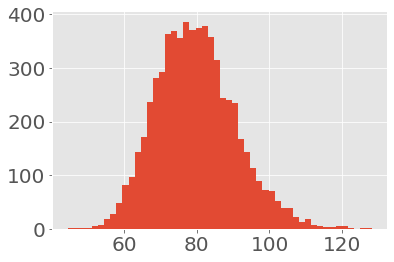

In [102]:
nonvaso_full_join.groupby(['icustay_id'])['meanbp'].mean().hist(bins=50)

In [118]:
max_interval_data = full_join.groupby('icustay_id').agg({'interval_index': max}).reset_index()
max_interval_data[max_interval_data.interval_index == 10]

,icustay_id,interval_index
0,200003,10.0
1,200019,10.0
2,200030,10.0
3,200036,10.0
4,200059,10.0
...,...,...
10062,299969,10.0
10063,299988,10.0
10064,299992,10.0
10065,299995,10.0


In [17]:
con.close()